In [3]:
from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP
from skimage.metrics import structural_similarity as ssim

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [6]:

image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
# net.built=True
# net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [8]:

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

with strategy.scope():
    image_shape = (1024, 1024, 1)
    inputs = tf.keras.Input(shape=image_shape)
    net = U2NET(1)
    out = net(inputs)
    net.built=True
    net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

    model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [7]:
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb,all_images_rgb, test_size=0.2 )

In [10]:
optim=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)
model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history=model.fit(x_train[:150], y_train[:150],
                        epochs=50,
                        batch_size=2,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/50
75/75 [==============================] - 62s 719ms/step - loss: 0.0244 - MAE: 0.1156 - val_loss: 0.2102 - val_MAE: 0.4257
Epoch 2/50
75/75 [==============================] - 52s 698ms/step - loss: 0.0196 - MAE: 0.1062 - val_loss: 0.0344 - val_MAE: 0.1450
Epoch 3/50
75/75 [==============================] - 52s 697ms/step - loss: 0.0184 - MAE: 0.1015 - val_loss: 0.0164 - val_MAE: 0.0928
Epoch 4/50
75/75 [==============================] - 52s 700ms/step - loss: 0.0165 - MAE: 0.0959 - val_loss: 0.0164 - val_MAE: 0.0884
Epoch 5/50
75/75 [==============================] - 53s 704ms/step - loss: 0.0145 - MAE: 0.0901 - val_loss: 0.0160 - val_MAE: 0.0914
Epoch 6/50
75/75 [==============================] - 52s 701ms/step - loss: 0.0158 - MAE: 0.0939 - val_loss: 0.0383 - val_MAE: 0.1431
Epoch 7/50
75/75 [==============================] - 53s 703ms/step - loss: 0.0143 - MAE: 0.0880 - val_loss: 0.0314 - val_MAE: 0.1255
Epoch 8/50
75/75 [==============================] - 53s 705ms/step - 

KeyboardInterrupt: 

In [34]:
loss=0.0089
net.save_weights(f'u2net_loss={loss}.h5')

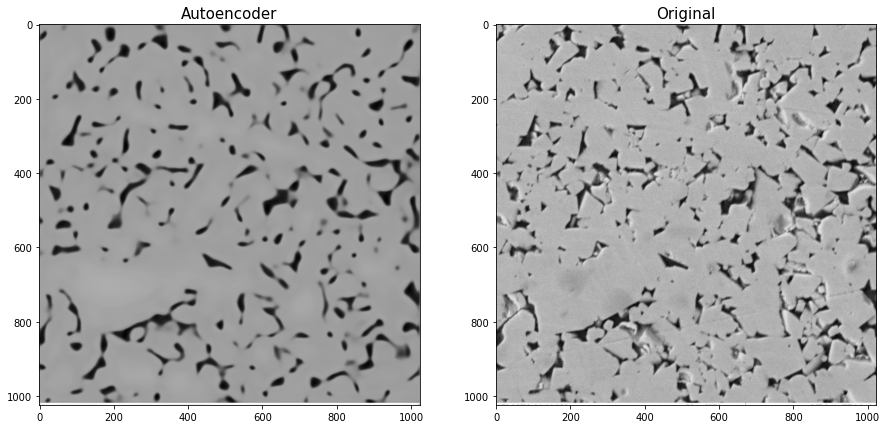

In [13]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
predict=net(tf.expand_dims(x_test[3],axis=0))[0][0]

original=x_test[3]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
plt.savefig(f'autoencoder_test_loss={loss}.png')
plt.show()

In [14]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().shape

(32, 32, 512)

## Visualization

In [15]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized/255,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [16]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(images_embs)

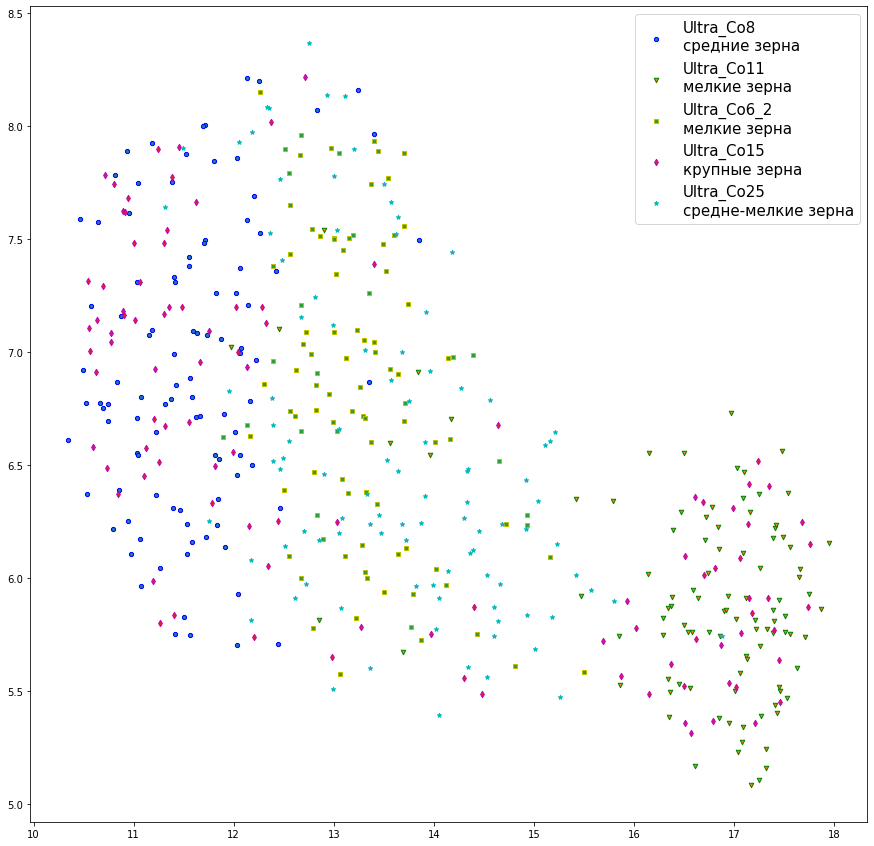

In [17]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)

    ax.scatter(umaped_vct[start:end, 0], umaped_vct[start:end, 1],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
plt.savefig(f'embs_space_loss={loss}.png')
plt.show()

In [19]:
umap_3d = UMAP(n_components=3)
umaped_vct_3d = umap_3d.fit_transform(images_embs)

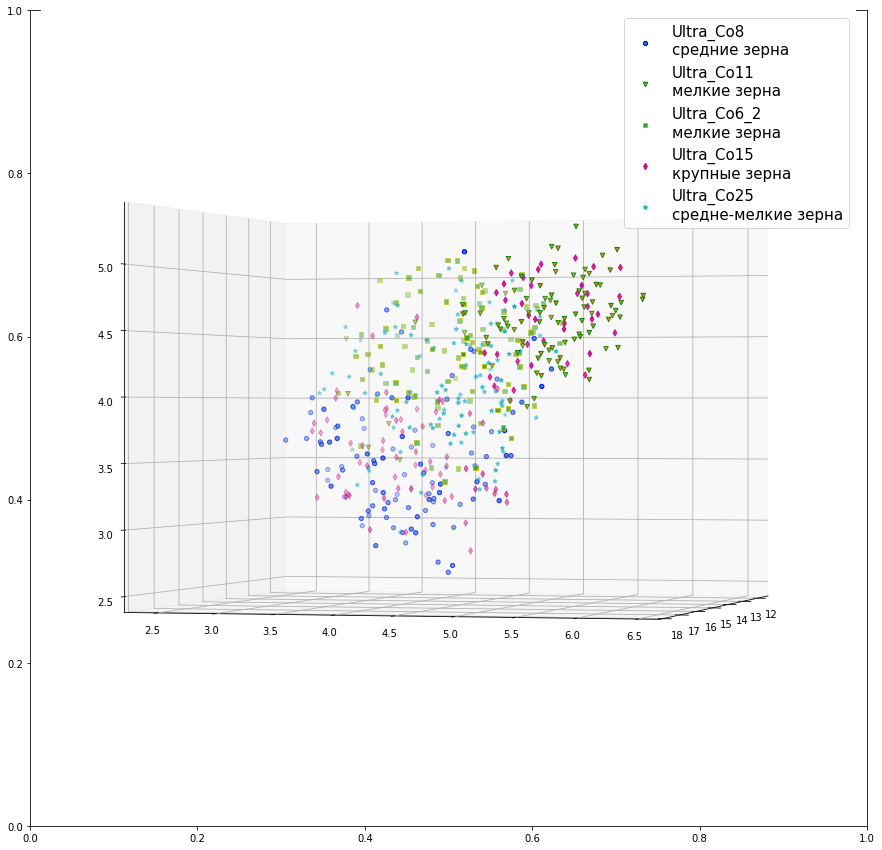

In [33]:
N = 15
fig, ax = plt.subplots(figsize=(N, N))
size = 20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

ax = plt.axes(projection='3d')
for i, images_list in enumerate(all_images):
    start = 0
    for j in range(i):
        start += len(all_images[j])
    end = start + len(images_list)

    ax.scatter3D(umaped_vct_3d[start:end, 0], umaped_vct_3d[start:end, 1],umaped_vct_3d[start:end, 2], edgecolor=colors[i], s=size, marker=markers[i])
  #  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

ax.legend(names, fontsize=15)
#plt.savefig(f'embs_space_3d_loss={loss}.png')
ax.view_init(0,15)
plt.show()

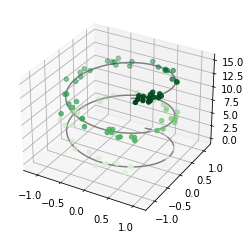

In [18]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');